### Helpers for training (ex. configuring data, metrics,,)

In [1]:
import os
import time
from argparse import Namespace
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchsummary

from pororo import Pororo

    
class UnsmileDataset(Dataset):
    '''
    unsmile_df(pandas.DataFrame): unsmile dataset with vectorized sentence('문장')
    '''
    def __init__(self, unsmile_df):
        self.unsmile_df = unsmile_df
      
    def __len__(self):
        return self.unsmile_df.shape[0]
      
    def __getitem__(self, index):
        sentence_vector = self.unsmile_df.iloc[index][0].reshape(1, -1) # for Conv1d
        label_vector = self.unsmile_df.iloc[index][1:].to_numpy(dtype=np.int32) # note dtype
        return sentence_vector, label_vector

def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device='cpu'):
    '''
    returns iterator for batch-size data.
    
    1. drop_last set to True: if the number of data is not divisible by batch size,
    do not use the last batch whose size is smaller than batch size

    2. shuffle set to True: shuffle dataset at every epoch
    '''

    train_dataloader = DataLoader(dataset=dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)
  
    for sentences, labels in train_dataloader:
        sentences = sentences.to(device)
        labels = labels.to(device)
        yield sentences, labels
        
def prune_dataset(data_file):
    data_dir = os.getcwd() + '/dataset/korean_unsmile_dataset/'
    # data_dir = os.getcwd() + '/drive/MyDrive/dataset/korean_unsmile_dataset-main/'
    df = pd.read_csv(data_dir + data_file, sep='\t')

    categories = df.columns.to_list()[1:]

    for category in categories:
        if category == 'clean':
            continue
        
        indexes = list()
        for i, _ in df.iterrows():
            data = df.loc[i]
            if data[category] == 1:
                indexes.append(i)

        mask = np.random.random(len(indexes)) > 0.5
        indexes = mask * indexes
        df.drop(indexes, inplace=True, errors='ignore')
    
    return df

def vectorize_dataset(df, vectorizer):
    '''
    transform '문장' column's elements from string to numpy array,
    and return the pandas dataframe. Pororo is used for sentence embedding.
    '''
    
    arr = []
    sentence_col = df.columns.to_list()[0]
    
    for i, _ in df.iterrows():
        vectorized_sentence = vectorizer(df.loc[i][sentence_col])
        arr.append(vectorized_sentence)

    s = pd.Series(arr, name=sentence_col)
    df.drop(columns=sentence_col, axis=1, inplace=True) # remove a column with raw sentences
    return pd.concat([s, df], axis=1)

def compute_metrics(y_pred, y_label, prev_precision):
    '''
    calculate precision and recall of batch-size data    
    '''
    
    y_label = y_label.cpu()
    y_pred = (torch.sigmoid(y_pred) > 0.5).cpu().int()
    
    if y_pred.sum().item() == 0:
        precision = prev_precision
    else:
        precision = y_label[y_pred == 1].sum().item() / y_pred.sum().item()
        
    recall = y_label[y_pred == 1].sum().item() / (y_label == 1).sum().item()
    return precision, recall

def make_train_state(args):
    return {'train_loss': [], 'test_loss': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': []}

def count(df):
    clean_data_num = df.sum()[-2]
    hatred_data_num = df.sum()[1:].sum() - clean_data_num
    print(f'hatred data: {hatred_data_num}, clean data: {clean_data_num}')

### Model

In [137]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        
        start_channels = 1
        num_classes = 11
        
        self.conv= nn.Sequential(
            nn.Conv1d(in_channels=start_channels, out_channels=32, kernel_size=13, stride=7),
            nn.ELU(),
            
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=11, stride=5),
            nn.ELU(),
            
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, stride=5),
            nn.ELU(),
            
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ELU(),
        )
        
        self.fc = nn.Linear(in_features=256, out_features=num_classes)

    def forward(self, x):
        x = self.conv(x).squeeze(dim=2)
        x = self.fc(x)
        return x

In [138]:
model = CNNClassifier()

torchsummary.summary(model, (1, 768), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 108]             448
               ELU-2              [-1, 32, 108]               0
            Conv1d-3               [-1, 64, 20]          22,592
               ELU-4               [-1, 64, 20]               0
            Conv1d-5               [-1, 128, 3]          57,472
               ELU-6               [-1, 128, 3]               0
            Conv1d-7               [-1, 256, 1]          98,560
               ELU-8               [-1, 256, 1]               0
            Linear-9                   [-1, 11]           2,827
Total params: 181,899
Trainable params: 181,899
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.69
Estimated Total Size (MB): 0.78
-------------------------------------------

### Prepare dataset

In [6]:
data_dir = os.getcwd() + '/dataset/korean_unsmile_dataset/'
train_data_file = 'unsmile_train_v1.0.tsv'
test_data_file = 'unsmile_valid_v1.0.tsv'
processed_train_data_file = 'cleaned_unsmile_train_v1.0.tsv'
processed_test_data_file = 'cleaned_unsmile_valid_v1.0.tsv'

vectorizer = Pororo(task='sentence_embedding', lang='ko')

In [7]:
train_df = pd.read_csv(data_dir + train_data_file, sep='\t')
test_df = pd.read_csv(data_dir + test_data_file, sep='\t')

# the original implementation was that the sentence is vectorized dynamically,
# but it spends quite a long time(about 150 sec) to vectorize one sentence.
# so vectorize all sentences in advance and keep in memory.
vectorized_train_df = vectorize_dataset(train_df, vectorizer)
vectorized_test_df = vectorize_dataset(test_df, vectorizer)

# original data
train_data = UnsmileDataset(vectorized_train_df)
test_data = UnsmileDataset(vectorized_test_df)

### Train model

In [140]:
args = Namespace(
    batch_size=128,
    learning_rate=0.001,
    num_epochs=15,
    cuda=False,
    device='cpu'
)

train_state = make_train_state(args)

if torch.cuda.is_available():
    args.cuda = True
args.device = torch.device('cuda' if args.cuda else 'cpu')

# model
model = CNNClassifier()
model = model.to(args.device)

# loss and optimizer
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=args.learning_rate)

# train starts
start_time = time.time()
print(f'<training start!>')
print(f'-learning rate: {args.learning_rate}')
print(f'-total epochs: {args.num_epochs}')
print(f'-batch size: {args.batch_size}')
print(f"-cuda {'avaialble' if args.cuda else 'not available'}")
    
for epoch_index in range(args.num_epochs):
    print(f'epoch{epoch_index + 1} : [', end='')

    running_loss = 0.0
    running_precision = 0.0
    running_recall = 0.0
    model.train() # this has effects on certain modules (ex, dropout)
  
    batch_generator = generate_batches(train_data, args.batch_size, device=args.device)

    for batch_index, (x, y) in enumerate(batch_generator):
        if batch_index % (int(int(len(train_data) / args.batch_size) / 20)) == 0:
            print('>', end='')
        
        # set all gradients to zero
        optimizer.zero_grad()
        
        # forward pass
        y_pred = model(x)
        loss = loss_func(y_pred, y.float())
    
        # backward pass
        loss.backward()
        optimizer.step()
        
        # metrics
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1) # moving average
        batch_precision, batch_recall = compute_metrics(y_pred, y, running_precision)
        running_precision += (batch_precision - running_precision) / (batch_index + 1)
        running_recall += (batch_recall - running_recall) / (batch_index + 1)
    
    print(']')
    train_state['train_loss'].append(running_loss)
    train_state['train_precision'].append(running_precision)
    train_state['train_recall'].append(running_recall)
  
    running_loss = 0.0
    running_precision = 0.0
    running_recall = 0.0
    model.eval()

    batch_generator = generate_batches(test_data, args.batch_size, device=args.device)
    
    for batch_index, (x, y) in enumerate(batch_generator):
        # forward pass
        y_pred = model(x)
        loss = loss_func(y_pred, y.float())
        
        # metrics
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1) # moving average
        batch_precision, batch_recall = compute_metrics(y_pred, y, running_precision)
        running_precision += (batch_precision - running_precision) / (batch_index + 1)
        running_recall += (batch_recall - running_recall) / (batch_index + 1)
  
    train_state['test_loss'].append(running_loss)
    train_state['test_precision'].append(running_precision)
    train_state['test_recall'].append(running_recall)

print(f'time flied: {time.time() - start_time: .0f} sec')
print('<end training!>')

<training start!>
-learning rate: 0.001
-total epochs: 15
-batch size: 128
-cuda avaialble
epoch1 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch2 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch3 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch4 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch5 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch6 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch7 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch8 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch9 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch10 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch11 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch12 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch13 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch14 : [>>>>>>>>>>>>>>>>>>>>>>>>]
epoch15 : [>>>>>>>>>>>>>>>>>>>>>>>>]
time flied:  94 sec
<end training!>


### Visualization of performance during training

-Final (moving average) values from the last epoch
train loss: 0.15055855026102472
test loss: 0.17649417447632756
train precision: 0.7705246897690642
test precision: 0.7069399178310878
train recall: 0.5631565927859538
test recall: 0.528181795683058


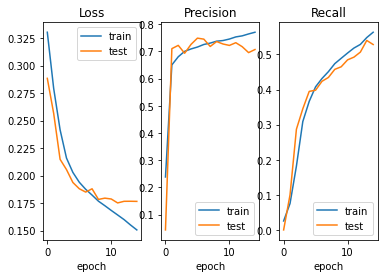

In [141]:
plt.subplot(1, 3, 1)
plt.title('Loss')
plt.xlabel('epoch')
plt.plot(np.arange(0, args.num_epochs), train_state['train_loss'])
plt.plot(np.arange(0, args.num_epochs), train_state['test_loss'])
plt.legend(['train', 'test'])

plt.subplot(1, 3, 2)
plt.title('Precision')
plt.xlabel('epoch')
plt.plot(np.arange(0, args.num_epochs), train_state['train_precision'])
plt.plot(np.arange(0, args.num_epochs), train_state['test_precision'])
plt.legend(['train', 'test'])

plt.subplot(1, 3, 3)
plt.title('Recall')
plt.xlabel('epoch')
plt.plot(np.arange(0, args.num_epochs), train_state['train_recall'])
plt.plot(np.arange(0, args.num_epochs), train_state['test_recall'])
plt.legend(['train', 'test'])

plt.plot()

print('-Final (moving average) values from the last epoch')
print(f"train loss: {train_state['train_loss'][-1]}")
print(f"test loss: {train_state['test_loss'][-1]}")
print(f"train precision: {train_state['train_precision'][-1]}")
print(f"test precision: {train_state['test_precision'][-1]}")
print(f"train recall: {train_state['train_recall'][-1]}")
print(f"test recall: {train_state['test_recall'][-1]}")


train_data_generator = generate_batches(train_data, 1, device=args.device)
test_data_generator = generate_batches(test_data, 1, device=args.device)

train_loss = 0
test_loss = 0 

for index, (x, y) in enumerate(train_data_generator):
    y_pred = model(x)
    loss = loss_func(y_pred, y.float())
    train_loss += loss.item()
train_loss /= len(train_data)


for index, (x, y) in enumerate(test_data_generator):
    y_pred = model(x)
    loss = loss_func(y_pred, y.float())
    test_loss += loss.item()
test_loss /= len(test_data)

### Performance details

In [142]:
# total test data metrics: precision and recall
batch_generator = generate_batches(test_data, 1, device=args.device)

y_preds = []
y_labels = []

for batch_index, (x, y) in enumerate(batch_generator):
    y_pred = model(x)
    y_pred = (torch.sigmoid(y_pred) > 0.5).int()
    y_preds.append(y_pred.detach().cpu().numpy().reshape(-1))
    y_labels.append(y.detach().cpu().numpy().reshape(-1))

y_preds = np.array(y_preds)
y_labels = np.array(y_labels)

precisions = []
recalls = []
col_num = len(vectorized_train_df.columns[1:])

for i in range(col_num):
    pred_col = y_preds[:, i]
    label_col = y_labels[:, i]
    
    # precision and recall
    if pred_col.sum() == 0:
        precision = -1 # undefined
    else:
        precision = (label_col[pred_col == 1] == 1).sum() / pred_col.sum()
    recall = (label_col[pred_col == 1] == 1).sum() / label_col.sum()
    
    precisions.append(precision)    
    recalls.append(recall)

# precision, recall, f1-score for each category
print('-Test data result of each category\ncategory     precision  recall  f1-score')
for category, precision, recall in zip(vectorized_train_df.columns[1:], precisions, recalls):
    if precision == -1:
        print(f'{category:10}\tundefined\t{recall: .3f}\tundefined')
    else:
        f1_score = 2 * precision * recall / (precision + recall)
        print(f'{category:10}\t{precision: .3f}\t{recall: .3f}\t{f1_score: .3f}')

    
# total precision and recall
total_precision = y_labels[y_preds == 1].sum() / y_preds.sum()
total_recall = y_labels[y_preds == 1].sum() / y_labels.sum()
total_f1_score = 2 * total_precision * total_recall / (total_precision + total_recall)
print(f'\n-Total performance')
print(f'precision: {total_precision: .3f}')
print(f'recall: {total_recall: .3f}')
print(f'f1 score: {total_f1_score: .3f}')

# '개인지칭' 과 '기타 혐오' 의 성능이 매우 낮음,, 왜?
# 데이터 통계를 보면, '개인지칭', '기타 혐오', '연령' 순서대로 데이터 수가 가장 적다. -> 적은 데이터 수가 문제?
# 그런데 '연령' 보다 '악플/욕설' 데이터 수가 약 5배 많음에도 불구하고, recall 은 큰 차이 안남,,
# 반대로, recall 이 가장 높은 '지역' 이나 '종교' 데이터 수가 많은 것도 아님.

-Test data result of each category
category     precision  recall  f1-score
여성/가족     	 0.736	 0.459	 0.566
남성        	 0.692	 0.632	 0.660
성소수자      	 0.843	 0.650	 0.734
인종/국적     	 0.701	 0.540	 0.610
연령        	 0.575	 0.575	 0.575
지역        	 0.806	 0.669	 0.731
종교        	 0.837	 0.762	 0.798
기타 혐오     	 0.559	 0.142	 0.226
악플/욕설     	 0.661	 0.282	 0.396
clean     	 0.666	 0.647	 0.657
개인지칭      	 0.438	 0.189	 0.264

-Total performance
precision:  0.707
recall:  0.528
f1 score:  0.605


### Baseline performance provided by Smilegate

               precision    recall  f1-score   support

     여성/가족      0.85      0.70      0.76       394
         남성      0.87      0.83      0.85       334
      성소수자      0.90      0.78      0.83       280
     인종/국적      0.87      0.79      0.82       426
         연령      0.92      0.75      0.83       146
         지역      0.87      0.88      0.88       260
         종교      0.87      0.86      0.87       290
      기타혐오      0.92      0.18      0.30       134
     악플/욕설      0.76      0.59      0.67       786
       clean      0.74      0.79      0.77       935

    micro avg      0.82      0.73      0.77      3985
    macro avg      0.86      0.72      0.76      3985
    weighted avg   0.82      0.73      0.77      3985
    samples avg    0.76      0.74      0.75      3985
